1. Query icepyx; see what tracks are available in area of interest

2. Save track numbers, beams, and repeat numbers into a dictionary

3. For each track/beam combination, loop over all possible repeat pairs

    A. Load all beams and all repeats for that track using icepyx (?). For all beams / repeats:
    
        - Do whatever we are doing with ATL03
    
        - Fill in nan gaps with noise
        
    B. For each repeat pair:
        
        - Loop across the along track coordinates: 
        
            Choices: window size, search width, running average window size, step, where to save data geographically
            
            Output: Best lag, corresponding correlation coefficient, equivalent along-track velocity
            
        - Save results in a text file with date collected, dx from ATL03 processing, lat, lon, veloc, correlation coefficient, best lag, # contributing nans

In [1]:
# from icepyx import icesat2data as ipd
import os, glob, re, h5py, sys, pyproj, shutil
import matplotlib as plt
import shutil
import numpy as np
from pprint import pprint
from astropy.time import Time
from scipy.signal import correlate
from icepyx import query as ipqr
import datetime


%matplotlib inline

## to get new version of icepyx with rgt functionality:
# git clone <URL to icepyx repo>
# cd icepyx
# pip install -e . 

# the notebook from hackweek is outdated with this version


# Determine area of interest and date range

In [2]:
# Foundation Ice Stream
short_name = 'ATL06'
spatial_extent = [-65, -86, -55, -81]
date_range = ['2019-01-01','2019-06-31'] # i can't remember when the data starts

date_range = ['2018-03-01','2020-05-31']

# Query for entire time span of interest

This may need to be broken into chunks for future queries over very long periods of time

In [3]:
# region_a = ipd.Icesat2Data(short_name, spatial_extent, date_range, version='003')
print(Time.now())
region_a = ipqr.Query(short_name, spatial_extent, date_range, version = '003')
print(Time.now())

2020-09-29 18:05:17.888321
2020-09-29 18:06:11.410426


Information you might like to know

ATL06
['2018-03-01', '2020-05-31']
00:00:00
23:59:59
003
['01', '02', '03', '04', '05', '06', '07']
['0004', '0009', '0010', '0019', '0025', '0034', '0040', '0049', '0050', '0055', '0064', '0065', '0070', '0071', '0080', '0086', '0095', '0101', '0110', '0111', '0116', '0125', '0126', '0131', '0132', '0141', '0146', '0147', '0156', '0162', '0171', '0172', '0177', '0186', '0187', '0192', '0193', '0202', '0207', '0208', '0217', '0223', '0232', '0238', '0247', '0248', '0253', '0263', '0268', '0269', '0278', '0284', '0293', '0299', '0308', '0309', '0314', '0324', '0329', '0330', '0339', '0345', '0354', '0360', '0369', '0370', '0375', '0385', '0390', '0391', '0400', '0406', '0415', '0421', '0430', '0431', '0436', '0446', '0451', '0452', '0461', '0467', '0476', '0482', '0491', '0492', '0497', '0507', '0512', '0513', '0522', '0528', '0537', '0543', '0552', '0553', '0558', '0567', '0568', '0573', '0574', '0583', '0588', '0589', '0598', '0604', '0613', '0614', '0619', '0628', '0629', '0634', '06

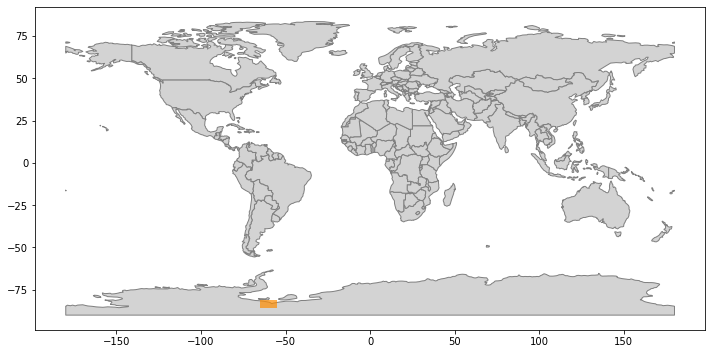

003


In [4]:
# information you might like to know:
print(region_a.dataset)
print(region_a.dates)
print(region_a.start_time)
print(region_a.end_time)
print(region_a.dataset_version)
print(region_a.cycles)
print(region_a.tracks) ## This is where tracks for this region are listed
# print(region_a.spatial_extent)
region_a.visualize_spatial_extent()

# region_a.visualize_spatial_extent()

print(region_a.latest_version())
#print(region_a.dataset_all_info())

In [5]:
# more information you might like to know
region_a.dataset_summary_info()
print(region_a.latest_version())
region_a.dataset_all_info()


dataset_id :  ATLAS/ICESat-2 L3A Land Ice Height V003
short_name :  ATL06
version_id :  003
time_start :  2018-10-14T00:00:00.000Z
coordinate_system :  CARTESIAN
summary :  This data set (ATL06) provides geolocated, land-ice surface heights (above the WGS 84 ellipsoid, ITRF2014 reference frame), plus ancillary parameters that can be used to interpret and assess the quality of the height estimates. The data were acquired by the Advanced Topographic Laser Altimeter System (ATLAS) instrument on board the Ice, Cloud and land Elevation Satellite-2 (ICESat-2) observatory.
orbit_parameters :  {'swath_width': '36.0', 'period': '96.8', 'inclination_angle': '92.0', 'number_of_orbits': '0.071428571', 'start_circular_latitude': '0.0'}
003
{'feed': {'entry': [{'archive_center': 'NASA NSIDC DAAC',
                     'associations': {'services': ['S1568899363-NSIDC_ECS',
                                                   'S1613669681-NSIDC_ECS',
                                                   'S

In [6]:
#build and view the parameters that will be submitted in our query
region_a.CMRparams

{'short_name': 'ATL06',
 'version': '003',
 'temporal': '2018-03-01T00:00:00Z,2020-05-31T23:59:59Z',
 'bounding_box': '-65,-86,-55,-81'}

Determine which granules are available from our search.

We'll sort these by rgt and use to download repeats of each rgt

In [7]:
#search for available granules and provide basic summary info about them
region_a.avail_granules()

{'Number of available granules': 1499,
 'Average size of granules (MB)': 98.11163795718043,
 'Total size of all granules (MB)': 147069.3452978134}

In [8]:
# simple script to extract information from granule hdf5 filename, as reported by nsidc
def info_from_granule(h5_file): 
    import datetime
    rgt = h5_file.split('_')[2][:4]
    cycle = (h5_file.split('_')[2])[4:6]

    year = int((h5_file.split('_')[1])[0:4])
    month = int((h5_file.split('_')[1])[4:6])
    day = int((h5_file.split('_')[1])[6:8])
    hour = int((h5_file.split('_')[1])[8:10])
    minute = int((h5_file.split('_')[1])[10:12])
    second = int((h5_file.split('_')[1])[12:])

    t = datetime.datetime(year,month,day,hour,minute,second)
    
    return rgt, cycle, t

In [9]:
#get a list of granule IDs for the available granules
available_granules = region_a.avail_granules(ids=True)
#print detailed information about the returned search results
# region_a.granules.avail # not useful at this point

# Sort granules by rgt, pulled from hdf5 filename
all_granules = {}
all_rgts = []
for granule in available_granules[0]:
    rgt, cycle, t = info_from_granule(granule)
    if not rgt in all_granules.keys():
        all_granules[rgt] = {}
    all_granules[rgt][cycle] = t
    all_rgts += [rgt]
    
# print(all_rgts)
print(all_granules['0848']['03'])

2019-05-23 19:50:46


Now, ``all_granules`` is a dictionary with a field for each granule, and the cycles with data


Loop over all rgts, download and process all repeats with cycle >= 2

In [10]:
tmp = []
for cycle in all_granules[rgt].keys():
    print(cycle)
    tmp += [int(cycle)]
print(tmp)

01
02
03
04
05
06
07
[1, 2, 3, 4, 5, 6, 7]


In [11]:
for cycle in all_granules[rgt].keys():
    files = glob.glob(path + '/*h5')
    path = './download_' + cycle
    for file in files:
        filename = file.split('/')[-1]
        shutil.move(file, './download/' + filename)


NameError: name 'path' is not defined

In [12]:
# if you want to try it with the long date range; i usually get the error "feed", but it goes away when I use shorter times
date_range = ['2018-03-01','2020-05-31']
rgt = '0848'
region_a = ipqr.Query(short_name, spatial_extent, date_range, version = '003', tracks=[rgt])
region_a.earthdata_login(earthdata_uid, email)

# need .netrc file set up to do the downloading in a loop
# https://icepyx.readthedocs.io/en/latest/user_guide/documentation/components.html?highlight=netrc#icepyx.core.Earthdata.Earthdata.login

# Place the order for granules
region_a.order_granules()
# region_a.order_granules(verbose=True)

# download the order
path = './download'
region_a.download_granules(path)


KeyError: 'feed'

In [15]:
# only rgt 0848 for right now

### WORK IN: only REQUEST DESIRED VARIABLES (subsetting)

earthdata_uid = 'cgbarcheck'
email = 'grace.barcheck@cornell.edu'

rgt = '0848'
rgt = '0659'
rgt = '0750'
for cycle in all_granules[rgt].keys():
    if int(cycle) >=3:
        t = all_granules[rgt][cycle]
        t2 = t
        t -= datetime.timedelta(days=10) # Tried 1 day, and it bugs out; 10 seems to work tho
        t2 += datetime.timedelta(days=10)
        date_range_tmp = [t.strftime('%Y-%m-%d'),t2.strftime('%Y-%m-%d')]
        print(cycle, date_range_tmp)
#         date_range = ['2018-03-01','2020-05-31']
        region_a = ipqr.Query(short_name, spatial_extent, date_range_tmp, version = '003', tracks=[rgt])
        region_a.earthdata_login(earthdata_uid, email)

        # Place the order for granules
        region_a.order_granules()
        # region_a.order_granules(verbose=True)
        
        # download the order
        path = './download_' + cycle
        region_a.download_granules(path)
        
        # move into common folder
        files = glob.glob(path + '/*h5')
        for file in files:
            filename = file.split('/')[-1]
            shutil.move(file, './download/' + filename)


03 ['2019-05-07', '2019-05-27']
Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000888412
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000000888412 of  1  order(s) is downloaded.
Download complete
04 ['2019-08-06', '2019-08-26']
Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000888414
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000000888414 of  1  order(s) is downloaded.
Download complete
05 ['2019-11-05', '2019-11-25']
Total number of data ord

In [17]:
!ls -lrt




total 9592
-rw-r--r--@  1 grace  staff  226293 Jul 22 14:04 0537_measures.png
-rw-r--r--@  1 grace  staff   55371 Jul 22 14:04 537_velocity.png
-rw-r--r--@  1 grace  staff   16551 Jul 22 14:04 BenH_LoopOverAllFiles_20200629.ipynb
-rw-r--r--@  1 grace  staff   16751 Jul 22 14:04 BenH_LoopOverAllFiles_20200629_ORIGINAL.ipynb
-rw-r--r--@  1 grace  staff   50164 Jul 22 14:04 BenH_SHARE_2_test_xcorr_FIS.ipynb
-rw-r--r--@  1 grace  staff   53050 Jul 22 14:04 BenH_SHARE_2_test_xcorr_FIS_GBworking.ipynb
-rw-r--r--@  1 grace  staff   50164 Jul 22 14:04 BenH_SHARE_2_test_xcorr_FIS_adding_static_surface.ipynb
-rw-r--r--@  1 grace  staff  460430 Jul 22 14:04 Corr_Coeff.gif
-rw-r--r--@  1 grace  staff  499227 Jul 22 14:04 Demo_data_download.ipynb
-rw-r--r--@  1 grace  staff  422351 Jul 22 14:04 FISimage.PNG
-rw-r--r--@  1 grace  staff  209750 Jul 22 14:04 Figure_96.png
-rw-r--r--@  1 grace  staff   52919 Jul 22 14:04 Final_notebook_s_v-Copy1.ipynb

-rw-r--r--@  1 grace  staff  209750 Jul 22 14:04 M

# Nothing useful after here

In [119]:
!ls download/


processed_ATL06_20190523195046_08480311_003_01.h5


In [34]:
earthdata_uid = 'cgbarcheck'
email = 'grace.barcheck@cornell.edu'
region_a.earthdata_login(earthdata_uid, email)

Earthdata Login password: ········


In [35]:
# Place the order for granules
region_a.order_granules()
# region_a.order_granules(verbose=True)

Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000766179
Initial status of your order request at NSIDC is:  pending
Your order status is still  pending  at NSIDC. Please continue waiting... this may take a few moments.
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete


In [37]:
#view a short list of order IDs
region_a.granules.orderIDs

['5000000766179']

In [38]:
# download the order
path = './download'
region_a.download_granules(path)

Beginning download of zipped output...
Data request 5000000766179 of  1  order(s) is downloaded.
Download complete


In [ ]:
# cool; it works; will have to come up with a way to get info about all repeats of all tracks, then download and process in chunks

In [41]:
!ls download/

processed_ATL06_20190523195046_08480311_003_01.h5


# reproduce the data acess in the example notebook

In [20]:
#polygon vertices (here equivalent to the bounding box, above)
short_name = 'ATL06'
spatial_extent = [(-55, 68), (-55, 71), (-48, 71), (-48, 68), (-55, 68)]
date_range = ['2019-02-20','2019-02-28']

region_a = ipqr.Query(short_name, spatial_extent, date_range, \
   cycles='02', tracks=['0849','0902'])

In [21]:
region_a.tracks
# yep, this works fine; short time period probably helps
# so the method will need to be, increment in 5 day increments or something, pull all tracks in that period, loop over them, 
# look for repeats at increments of ~91 days out

['0849', '0902']

In [22]:
91/10

9.1

In [115]:
# one rgt THS ONE WORKS, DONT DELETE
rgt = '0848'
date_range = ['2018-03-01','2020-05-31']
date_range = ['2019-05-15','2019-05-31'] # need to run on a slightly shorter time or it bus out

region_a = ipqr.Query(short_name, spatial_extent, date_range, \
   tracks=[rgt])
print(region_a.tracks)



['0848']


In [11]:
def info_from_granule(h5_file): 
    # eventually: get date out as well
    rgt = h5_file.split('_')[2][:4]
    
#     year = (h5_file.split('_')[1])[0:4]
#     month = (h5_file.split('_')[1])[4:6]
#     day = (h5_file.split('_')[1])[6:8]
#     hour = (h5_file.split('_')[1])[8:10]
#     minute = (h5_file.split('_')[1])[10:12]
#     second = (h5_file.split('_')[1])[12:]
    
    return rgt

In [12]:
rgts_all = []

for granule in region_a.avail_granules(ids=True)[0]:
    rgt = info_from_granule(granule)
    if rgt not in rgts_all:
        rgts_all += [rgt]
        
print(rgts_all)

['0238', '0247', '0248', '0253', '0254', '0263', '0268', '0278', '0284', '0299', '0308', '0309', '0314', '0324', '0330', '0339', '0345', '0354', '0360', '0369', '0370', '0375', '0385', '0390', '0391', '0400', '0406', '0415', '0421', '0430', '0431', '0436', '0446', '0451', '0452', '0461', '0467', '0476', '0482', '0491', '0492', '0497', '0507', '0512', '0513', '0522', '0528', '0537', '0543', '0552', '0553', '0558', '0567', '0568', '0573', '0574', '0583', '0589', '0598', '0613', '0614', '0628', '0629', '0634', '0635', '0644', '0650', '0659', '0665', '0675', '0680', '0705', '0710', '0711', '0720', '0726', '0735', '0741', '0751', '0756', '0766', '0771', '0772', '0781', '0787', '0796', '0802', '0811', '0812', '0817', '0827', '0832', '0833', '0842', '0848', '0857', '0863', '0873', '0878', '0888', '0893', '0894', '0903', '0909', '0918', '0924', '0933', '0934', '0949', '0955', '0964', '0970', '0979', '0985', '0994', '0995', '1000', '1010', '1015', '1016', '1025', '1031', '1055', '1056', '1061',

Other information you might like to have:

['0004', '0009', '0010', '0019', '0025', '0034', '0040', '0049', '0050', '0055', '0065', '0070', '0071', '0080', '0086', '0095', '0101', '0110', '0111', '0116', '0125', '0126', '0131', '0132', '0141', '0146', '0147', '0156', '0162', '0171', '0172', '0177', '0186', '0187', '0192', '0193', '0202', '0207', '0208', '0217', '0223', '0232', '0238', '0247', '0248', '0253', '0254', '0263', '0268', '0269', '0278', '0284', '0293', '0299', '0308', '0309', '0314', '0324', '0329', '0330', '0339', '0345', '0354', '0360', '0369', '0370', '0375', '0385', '0390', '0391', '0400', '0406', '0415', '0421', '0430', '0431', '0436', '0446', '0451', '0452', '0461', '0467', '0476', '0482', '0491', '0492', '0497', '0507', '0512', '0513', '0522', '0528', '0537', '0543', '0552', '0553', '0558', '0567', '0568', '0573', '0574', '0583', '0589', '0598', '0604', '0613', '0614', '0619', '0628', '0629', '0634', '0635', '0644', '0649', '0650', '0659', '0665', '0674', '0675', '0680', '0689', '0690', '0695', '0696', '0705',

# download repeat rgt data from one track

In [ ]:
'0848' in region_a.tracks

tracks = ['0848']

t0 = Time.now()
# region_a = ipd.Icesat2Data(short_name, spatial_extent, date_range, version='003')
region_a = ipqr.Query(short_name, spatial_extent, date_range, version = '003', tracks = tracks)

print('Took ' + str(Time.now() - t0) + ' seconds to query')

Figure out what data is available; this step takes a long time

In [ ]:
#build and view the parameters that will be submitted in our query
region_a.CMRparams



In [ ]:
#get a list of the available granule IDs that meet your search criteria TAKES A LONG TIME
t0 = Time.now()
print('Took ' + str(Time.now() - t0) + ' seconds to query available granules')



In [ ]:
region_a

In [ ]:
rgts = {}
for filepath in ATL06_files:
    filename = filepath.split('/')[-1]
    rgt = filename.split('_')[3][0:4]
    track = filename.split('_')[3][4:6]
#     print(rgt,track)
    if not rgt in rgts.keys():
        rgts[rgt] = []
        rgts[rgt].append(track)
    else:
        rgts[rgt].append(track)


# all rgt values in our study are are in rgts.keys()
print(rgts.keys())

# available tracks for each rgt are in rgts[rgt]; ex.:
print(rgts['0848'])

# let's work 0848, our first good track friend

In [ ]:
def atl06_to_dict(filename, beam, field_dict=None, index=None, epsg=None):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            beam: a string specifying which beam is to be read (ex: gt1l, gt1r, gt2l, etc)
            field_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
            index: which entries in each field to read
            epsg: an EPSG code specifying a projection (see www.epsg.org).  Good choices are:
                for Greenland, 3413 (polar stereographic projection, with Greenland along the Y axis)
                for Antarctica, 3031 (polar stereographic projection, centered on the Pouth Pole)
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a numpy array containing the 
                data
    """
    if field_dict is None:
        field_dict={None:['latitude','longitude','h_li', 'atl06_quality_summary'],\
                    'ground_track':['x_atc','y_atc'],\
                    'fit_statistics':['dh_fit_dx', 'dh_fit_dy']}
    D={}
    # below: file_re = regular expression, it will pull apart the regular expression to get the information from the filename
    file_re=re.compile('ATL06_(?P<date>\d+)_(?P<rgt>\d\d\d\d)(?P<cycle>\d\d)(?P<region>\d\d)_(?P<release>\d\d\d)_(?P<version>\d\d).h5')
    with h5py.File(filename,'r') as h5f:
        for key in field_dict:
            for ds in field_dict[key]:
                if key is not None:
                    ds_name=beam+'/land_ice_segments/'+key+'/'+ds
                else:
                    ds_name=beam+'/land_ice_segments/'+ds
                if index is not None:
                    D[ds]=np.array(h5f[ds_name][index])
                else:
                    D[ds]=np.array(h5f[ds_name])
                if '_FillValue' in h5f[ds_name].attrs:
                    bad_vals=D[ds]==h5f[ds_name].attrs['_FillValue']
                    D[ds]=D[ds].astype(float)
                    D[ds][bad_vals]=np.NaN
        D['data_start_utc'] = h5f['/ancillary_data/data_start_utc'][:]
        D['delta_time'] = h5f['/' + beam + '/land_ice_segments/delta_time'][:]
        D['segment_id'] = h5f['/' + beam + '/land_ice_segments/segment_id'][:]
    if epsg is not None:
        xy=np.array(pyproj.proj.Proj(epsg)(D['longitude'], D['latitude']))
        D['x']=xy[0,:].reshape(D['latitude'].shape)
        D['y']=xy[1,:].reshape(D['latitude'].shape)
    temp=file_re.search(filename)
    D['rgt']=int(temp['rgt'])
    D['cycle']=int(temp['cycle'])
    D['beam']=beam
    return D

# A revised code to plot the elevations of segment midpoints (h_li):
def plot_elevation(D6, ind=None, **kwargs):
    """
    Plot midpoint elevation for each ATL06 segment
    """
    if ind is None:
        ind=np.ones_like(D6['h_li'], dtype=bool)
    # pull out heights of segment midpoints
    h_li = D6['h_li'][ind]
    # pull out along track x coordinates of segment midpoints
    x_atc = D6['x_atc'][ind]

    plt.plot(x_atc, h_li, **kwargs)

# Loop over rgts and do the correlation processing

TOMORROW: START WITH NEXT CELL IN OLD CODE, IMPLEMENT MAKING THE X1 VEC AND LOOPING

In [ ]:
cycles = ['03','04','05','06','07'] # not doing 1 and 2, because don't overlap exactly
# this could be future work

beams = ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']

# try and smooth without filling nans
dx = 20 # x_atc coordinate distance
smoothing_window_size = int(np.round(40 / dx)) # meters / dx;
# ex., 60 m smoothing window is a 3 point running average smoothed dataset, because each point is 20 m apart
filt = np.ones(smoothing_window_size)
smoothed = True

segment_length = 2000 # m
search_width = 800 # m


for rgt in rgts.keys():
    if rgt == '0848': # just want to work on this track for now
        
        ### load all files for this rgt
        rgt_files = glob.glob(os.path.join(datapath, f'*ATL06_*_{rgt}*_003*.h5'))
        
        ### extract data from all available cycles
        x_atc = {}
        h_li_raw = {}
        h_li = {}
        h_li_diff = {}
        times = {}
        min_seg_ids = {}
        min_x_atc = {}

        cycles_this_rgt = []
        for cycle in cycles:
            # load data that matches cycle; put into dictionaries to use shortly
            Di = {}
            x_atc[cycle] = {}
            h_li_raw[cycle] = {}
            h_li[cycle] = {}
            h_li_diff[cycle] = {}
            times[cycle] = {}
            min_seg_ids[cycle] = {}
            min_x_atc[cycle] = {}



            filenames = glob.glob(os.path.join(datapath, f'*ATL06_*_{rgt}{cycle}*_003*.h5'))
            print(filenames)
            error_count=0
            for filename in filenames:
                try:
                    for beam in beams:
                        Di[filename]=atl06_to_dict(filename,'/'+ beam, index=None, epsg=3031)

                        times[cycle][beam] = Di[filename]['data_start_utc']

                        # extract h_li and x_atc for that section                
                        x_atc_tmp = Di[filename]['x_atc']
                        h_li_tmp = Di[filename]['h_li']#[ixs]

                        # segment ids:
                        seg_ids = Di[filename]['segment_id']
                        min_seg_ids[cycle][beam] = seg_ids[0]
                        #print(len(seg_ids), len(x_atc_tmp))

                        # make a monotonically increasing x vector
                        # assumes dx = 20 exactly, so be carefull referencing back
                        ind = seg_ids - np.nanmin(seg_ids) # indices starting at zero, using the segment_id field, so any skipped segment will be kept in correct location
                        x_full = np.arange(np.max(ind)+1) * 20 + x_atc_tmp[0]
                        h_full = np.zeros(np.max(ind)+1) + np.NaN
                        h_full[ind] = h_li_tmp
                        min_x_atc[cycle][beam] = x_atc_tmp[0]


                        x_atc[cycle][beam] = x_full
                        h_li_raw[cycle][beam] = h_full

                        # running average smoother /filter
                        if smoothed == True:
                            h_smoothed = (1/smoothing_window_size) * np.convolve(filt, h_full, mode = 'same')
                            h_li[cycle][beam] = h_smoothed

                            # differentiate that section of data
                            h_diff = (h_smoothed[1:] - h_smoothed[0:-1]) / (x_full[1:] - x_full[0:-1])
                        else: 
                            h_li[cycle][beam] = h_full
                            h_diff = (h_full[1:] - h_full[0:-1]) / (x_full[1:] - x_full[0:-1])

                        h_li_diff[cycle][beam] = h_diff

#                         # plot
#                         axs[0].plot(x_full, h_full)
#                         axs[1].plot(x_full[1:], h_diff)
#         #                 axs[2].plot(x_atc_tmp[1:] - x_atc_tmp[:-1])
#                         axs[2].plot(np.isnan(h_full))
#                         axs[3].plot(seg_ids[1:]- seg_ids[:-1])


                    cycles_this_rgt+=[cycle]


                except KeyError as e:
                    print(f'file {filename} encountered error {e}')
                    error_count += 1
            
            print(f"For cycle {cycle}, read {len(Di)} data files of which {error_count} gave errors")
            
        ### Determine # of possible velocities:
        n_possible_veloc = len(cycles_this_rgt) -1 # naive, for now; can improve later
        for veloc_number in range(n_possible_veloc):
            cycle1 = cycles[veloc_number]
            cycle2 = cycles[veloc_number+1]
            t1_string = times[cycle1]['gt1l'][0].astype(str) #figure out later if just picking hte first one it ok
            t1 = Time(t1_string)

            t2_string = times[cycle2]['gt1l'][0].astype(str) #figure out later if just picking hte first one it ok
            t2 = Time(t2_string)

            dt = (t2 - t1).jd # difference in julian days
        
            velocities = {}     
            for beam in beams:
                # fig1, axs = plt.subplots(4,1)

                ### determine x1: larger value for both beams, if different
                x1 = np.nanmax([x_atc[cycle1][beam][0], x_atc[cycle2][beam][0]])                
                
                # cut out small chunk of data at time t1 (first cycle)
                x_full_t1 = x_atc[cycle1][beam]
                ix_x1 = np.arange(len(x_full_t1))[x_full_t1 >= x1][0]
                ix_x2 = ix_x1 + int(np.round(segment_length/dx))      
                x_t1 = x_full_t1[ix_x1:ix_x2]
                h_li1 = h_li_diff[cycle1][beam][ix_x1-1:ix_x2-1] # start 1 index earlier because the data are differentiated

                # cut out a wider chunk of data at time t2 (second cycle)
                x_full_t2 = x_atc[cycle2][beam]
                ix_x3 = ix_x1 - int(np.round(search_width/dx)) # offset on earlier end by # indices in search_width
                ix_x4 = ix_x2 + int(np.round(search_width/dx)) # offset on later end by # indices in search_width
                x_t2 = x_full_t2[ix_x3:ix_x4]
                h_li2 = h_li_diff[cycle2][beam][ix_x3:ix_x4]

                # plot data
                # axs[0].plot(x_t2, h_li2, 'r')
                # axs[0].plot(x_t1, h_li1, 'k')
                # axs[0].set_xlabel('x_atc (m)')

                # correlate old with newer data
                corr = correlate(h_li1, h_li2, mode = 'valid', method = 'direct') 

                # normalize correlation function; simplest way (not quite correct)
                # norm_val = np.sqrt(np.sum(h_li1**2)*np.sum(h_li2**2)) # normalize so values range between 0 and 1
                # corr = corr / norm_val

                # a better way to normalize correlation function: shifting along longer vector
                coeff_a_val = np.sum(h_li1**2)
                coeff_b_val = np.zeros(len(h_li2) - len(h_li1)+1)
                for shift in range(len(h_li2) - len(h_li1)+1):
                    coeff_b_val[shift] = np.sum(h_li2[shift:shift + len(h_li1)]**2)
                norm_vec = np.sqrt(coeff_a_val * coeff_b_val)
                corr = corr / norm_vec


        #         lagvec = np.arange( -(len(h_li1) - 1), len(h_li2), 1)# for mode = 'full'
        #         lagvec = np.arange( -int(search_width/dx) - 1, int(search_width/dx) +1, 1) # for mode = 'valid'
                lagvec = np.arange(- int(np.round(search_width/dx)), int(search_width/dx) +1,1)# for mode = 'valid'

                shift_vec = lagvec * dx

                ix_peak = np.arange(len(corr))[corr == np.nanmax(corr)][0]
                best_lag = lagvec[ix_peak]
                best_shift = shift_vec[ix_peak]
                velocities[beam] = best_shift/(dt/365)

                # axs[1].plot(lagvec,corr)
                # axs[1].plot(lagvec[ix_peak],corr[ix_peak], 'r*')
                # axs[1].set_xlabel('lag (samples)')

                # axs[2].plot(shift_vec,corr)
                # axs[2].plot(shift_vec[ix_peak],corr[ix_peak], 'r*')
                # axs[2].set_xlabel('shift (m)')

                ## plot shifted data
                # axs[3].plot(x_t2, h_li2, 'r')
                # axs[3].plot(x_t1 - best_shift, h_li1, 'k')
                # axs[3].set_xlabel('x_atc (m)')

                # axs[0].text(x_t2[100], 0.6*np.nanmax(h_li2), beam)
                # axs[1].text(lagvec[5], 0.6*np.nanmax(corr), 'best lag: ' + str(best_lag) + '; corr val: ' + str(np.round(corr[ix_peak],3)))
                # axs[2].text(shift_vec[5], 0.6*np.nanmax(corr), 'best shift: ' + str(best_shift) + ' m'+ '; corr val: ' + str(np.round(corr[ix_peak],3)))
                # axs[2].text(shift_vec[5], 0.3*np.nanmax(corr), 'veloc of ' + str(np.round(best_shift/(dt/365),1)) + ' m/yr')


            
        
#         Di={}
#         error_count=0
#         for file in rgt_files:
#             try:
#                 D_dict[file]=atl06_to_dict(file, '/gt2l', index=slice(0, -1, 25), epsg=3031)
#             except KeyError as e:
#                 print(f'file {file} encountered error {e}')
#                 error_count += 1
#         print(f"read {len(D_dict)} data files of which {error_count} gave errors")
            


In [ ]:
cycles_this_rgt

In [ ]:
min_x_atc